In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize_scalar
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

# DataSet C250-9

In [2]:
def get_adj_matrix(path):
    M = mmread(path).tocsr()
    # check if the loaded matrix is symmetric
    is_symmetric = (M != M.T).nnz == 0
    if not is_symmetric:
        M = M.maximum(M.T)

    M.setdiag(0)
    M.eliminate_zeros()
    return M

In [3]:
A = get_adj_matrix("/Users/aleksandramaslova/Downloads/C250-9/C250-9.mtx")

# Show basic info
print("Shape:", A.shape)
print("Number of nonzeros:", A.nnz)

Shape: (250, 250)
Number of nonzeros: 55968


#### Objective Functions

In [4]:
# equation 31
def obj_l2(x, A, alpha = 0.5):
    return x.T @ A @ x + alpha * (x @ x)

def grad_l2(x, A, alpha = 0.5):
    return 2 * A @ x + alpha * 2 * x

# equation 33
def obj_l0(x, A, alpha=0.07, beta=5):
    val = x.T @ (A @ x)
    return float(val) + alpha * np.sum(np.exp(-beta * x) - 1)

def grad_l0(x, A, alpha=0.07, beta=5):
    return 2 * (A @ x) - alpha * beta * np.exp(-beta * x)

#### Utility Functions

In [5]:
def LMO(gradient):
    i = np.argmin(gradient)
    s_fw = np.zeros_like(gradient)
    s_fw[i] = 1.0
    return s_fw

def exact_line_search(func, x, direction, max_step):
    if max_step <= 1e-12:
        return 0.0
    phi = lambda gamma: -func(x + gamma * direction)
    res = minimize_scalar(phi, bounds=(0, max_step), method='bounded')
    return res.x

def armijo_line_search(func, x, grad, direction, max_iter=100, initial_step = 1.0):
    cur_val = func(x, A)
    step = initial_step
    for _ in range(max_iter):
        x_new = x + step * direction
        new_val = func(x_new, A)
        if new_val >= cur_val + 0.1 * step * np.dot(grad, direction):
            return step
        step *= 0.5
    return 0.0

def away_step_vertex(x, gradient):
    active_set = np.where(x > 0)[0]
    if len(active_set) == 0:
        raise ValueError("Active set is empty.")
    worst_vertex = active_set[np.argmax(gradient[active_set])]
    v = np.zeros_like(x)
    v[worst_vertex] = 1.0
    return v


In [6]:
def extract_clique_from_solution(x, W, threshold=0.01):
    """
    Extracts a clique from the solution vector x using a greedy strategy.
    """
    candidates = np.argsort(-x)  # sort by weight, descending
    clique = []

    for i in candidates:
        if x[i] < threshold:
            break
        if all(W[i, j] == 1 for j in clique):
            clique.append(i)

    clique_size = len(clique)

    return clique, clique_size


## Frank-Wolfe Algorithm

In [11]:
# Frank-Wolfe Algorithm
def frank_wolfe(obj_func, grad_obj_func, A, num_iters=100, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    x = np.ones(n) / n

    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(num_iters):
        grad = grad_obj_func(x, A)
        vertex = LMO(-grad)
        direction = vertex - x

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 2), 1.0)

        # Update
        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x
        
        if abs(cur_func - history[-2]) < tol:
            print(f"Converged at iteration {iter+1}, update = {cur_func - history[-2]:.2e}")
            break

        if verbose:
            print(f"Iter {iter+1:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history


#### Test Frank-Wolfe Algo on **l2-Regularized Objective Function**

##### Exact Line Search

In [8]:
x_opt_FW_exact_l2, history_FW_exact_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'exact')

Iter   1: f(x) = 0.902247, step = 0.0981
Iter   2: f(x) = 0.905849, step = 0.0861
Iter   3: f(x) = 0.909616, step = 0.0875
Iter   4: f(x) = 0.912996, step = 0.0830
Iter   5: f(x) = 0.916466, step = 0.0836
Iter   6: f(x) = 0.919963, step = 0.0836
Iter   7: f(x) = 0.923089, step = 0.0792
Iter   8: f(x) = 0.926208, step = 0.0788
Iter   9: f(x) = 0.929282, step = 0.0780
Iter  10: f(x) = 0.932281, step = 0.0769
Iter  11: f(x) = 0.935185, step = 0.0755
Iter  12: f(x) = 0.937976, step = 0.0739
Iter  13: f(x) = 0.940456, step = 0.0698
Iter  14: f(x) = 0.942843, step = 0.0684
Iter  15: f(x) = 0.945131, step = 0.0669
Iter  16: f(x) = 0.947316, step = 0.0653
Iter  17: f(x) = 0.949397, step = 0.0637
Iter  18: f(x) = 0.951259, step = 0.0603
Iter  19: f(x) = 0.953038, step = 0.0590
Iter  20: f(x) = 0.954737, step = 0.0576
Iter  21: f(x) = 0.956267, step = 0.0547
Iter  22: f(x) = 0.957733, step = 0.0536
Iter  23: f(x) = 0.959136, step = 0.0524
Iter  24: f(x) = 0.960408, step = 0.0499
Iter  25: f(x) =

In [12]:
clique_FW_exact_l2, size_clique_FW_exact_l2 = extract_clique_from_solution(x_opt_FW_exact_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_exact_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 36. The best known is of size 44.


##### Armijo Line Search

In [13]:
x_opt_FW_armijo_l2, history_FW_armijo_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'armijo')

Iter   1: f(x) = 0.901889, step = 0.1250
Iter   2: f(x) = 0.905204, step = 0.1250
Iter   3: f(x) = 0.909226, step = 0.1250
Iter   4: f(x) = 0.913016, step = 0.1250
Iter   5: f(x) = 0.917128, step = 0.1250
Iter   6: f(x) = 0.921333, step = 0.1250
Iter   7: f(x) = 0.925086, step = 0.1250
Iter   8: f(x) = 0.928818, step = 0.1250
Iter   9: f(x) = 0.932428, step = 0.1250
Iter  10: f(x) = 0.935849, step = 0.1250
Iter  11: f(x) = 0.939043, step = 0.1250
Iter  12: f(x) = 0.941993, step = 0.1250
Iter  13: f(x) = 0.944515, step = 0.1250
Iter  14: f(x) = 0.946854, step = 0.1250
Iter  15: f(x) = 0.949001, step = 0.1250
Iter  16: f(x) = 0.950957, step = 0.1250
Iter  17: f(x) = 0.952728, step = 0.1250
Iter  18: f(x) = 0.954232, step = 0.1250
Iter  19: f(x) = 0.955604, step = 0.1250
Iter  20: f(x) = 0.956847, step = 0.1250
Iter  21: f(x) = 0.957907, step = 0.1250
Iter  22: f(x) = 0.958874, step = 0.1250
Iter  23: f(x) = 0.961367, step = 0.0625
Iter  24: f(x) = 0.963591, step = 0.0625
Iter  25: f(x) =

In [14]:
clique_FW_armijo_l2, size_clique_FW_armijo_l2 = extract_clique_from_solution(x_opt_FW_armijo_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 38. The best known is of size 44.


##### Deminishing Step Size


In [15]:
x_opt_FW_demin_l2, history_FW_demin_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='demin')

Iter   1: f(x) = 0.500000, step = 1.0000
Iter   2: f(x) = 0.722222, step = 0.6667
Iter   3: f(x) = 0.805556, step = 0.5000
Iter   4: f(x) = 0.850000, step = 0.4000
Iter   5: f(x) = 0.877778, step = 0.3333
Iter   6: f(x) = 0.896825, step = 0.2857
Iter   7: f(x) = 0.910714, step = 0.2500
Iter   8: f(x) = 0.921296, step = 0.2222
Iter   9: f(x) = 0.929630, step = 0.2000
Iter  10: f(x) = 0.936364, step = 0.1818
Iter  11: f(x) = 0.941919, step = 0.1667
Iter  12: f(x) = 0.946581, step = 0.1538
Iter  13: f(x) = 0.950549, step = 0.1429
Iter  14: f(x) = 0.953968, step = 0.1333
Iter  15: f(x) = 0.956944, step = 0.1250
Iter  16: f(x) = 0.959559, step = 0.1176
Iter  17: f(x) = 0.961874, step = 0.1111
Iter  18: f(x) = 0.963938, step = 0.1053
Iter  19: f(x) = 0.965789, step = 0.1000
Iter  20: f(x) = 0.967460, step = 0.0952
Iter  21: f(x) = 0.968975, step = 0.0909
Iter  22: f(x) = 0.970356, step = 0.0870
Iter  23: f(x) = 0.971618, step = 0.0833
Iter  24: f(x) = 0.972778, step = 0.0800
Iter  25: f(x) =

In [16]:
clique_FW_demin_l2, size_clique_FW_demin_l2 = extract_clique_from_solution(x_opt_FW_demin_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_demin_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 31. The best known is of size 44.


##### Plot Convergence results

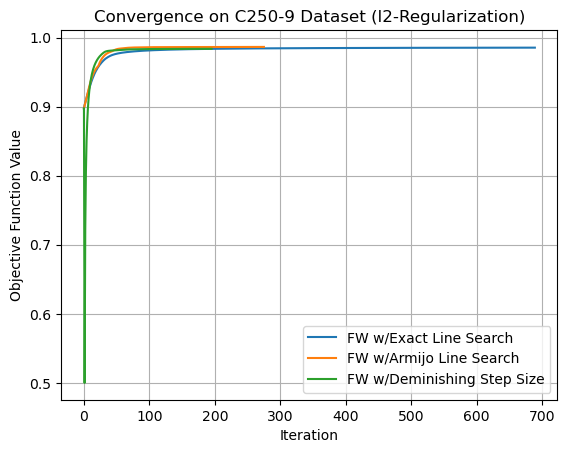

In [17]:
plt.plot(history_FW_exact_l2, label='FW w/Exact Line Search')
plt.plot(history_FW_armijo_l2, label='FW w/Armijo Line Search')
plt.plot(history_FW_demin_l2, label='FW w/Deminishing Step Size')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l2-Regularization)")
plt.legend()
plt.grid(True)
plt.show()



#### Test Frank-Wolfe Algo on **l0-Regularized Objective Function**

##### Exact Line Search

In [18]:
x_opt_FW_exact_l0, history_FW_exact_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'exact')

Iter   1: f(x) = 0.556585, step = 0.1325
Iter   2: f(x) = 0.562682, step = 0.1218
Iter   3: f(x) = 0.568897, step = 0.1218
Iter   4: f(x) = 0.574438, step = 0.1163
Iter   5: f(x) = 0.579851, step = 0.1148
Iter   6: f(x) = 0.585019, step = 0.1123
Iter   7: f(x) = 0.589512, step = 0.1064
Iter   8: f(x) = 0.593746, step = 0.1038
Iter   9: f(x) = 0.597694, step = 0.1008
Iter  10: f(x) = 0.601348, step = 0.0977
Iter  11: f(x) = 0.604711, step = 0.0945
Iter  12: f(x) = 0.607794, step = 0.0913
Iter  13: f(x) = 0.610456, step = 0.0863
Iter  14: f(x) = 0.612910, step = 0.0836
Iter  15: f(x) = 0.615171, step = 0.0809
Iter  16: f(x) = 0.617251, step = 0.0783
Iter  17: f(x) = 0.619164, step = 0.0758
Iter  18: f(x) = 0.620837, step = 0.0720
Iter  19: f(x) = 0.622388, step = 0.0698
Iter  20: f(x) = 0.623826, step = 0.0678
Iter  21: f(x) = 0.624878, step = 0.0553
Iter  22: f(x) = 0.626092, step = 0.0634
Iter  23: f(x) = 0.627222, step = 0.0617
Iter  24: f(x) = 0.628277, step = 0.0600
Iter  25: f(x) =

In [19]:
clique_FW_exact_l0, size_clique_FW_exact_l0 = extract_clique_from_solution(x_opt_FW_exact_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_exact_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 35. The best known is of size 44.


##### Armijo Line Search

In [20]:
x_opt_FW_armijo_l0, history_FW_armijo_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'armijo')

Iter   1: f(x) = 0.556555, step = 0.1250
Iter   2: f(x) = 0.562516, step = 0.1250
Iter   3: f(x) = 0.568701, step = 0.1250
Iter   4: f(x) = 0.574239, step = 0.1250
Iter   5: f(x) = 0.579747, step = 0.1250
Iter   6: f(x) = 0.585058, step = 0.1250
Iter   7: f(x) = 0.589680, step = 0.1250
Iter   8: f(x) = 0.594089, step = 0.1250
Iter   9: f(x) = 0.598223, step = 0.1250
Iter  10: f(x) = 0.602048, step = 0.1250
Iter  11: f(x) = 0.605552, step = 0.1250
Iter  12: f(x) = 0.608735, step = 0.1250
Iter  13: f(x) = 0.611435, step = 0.1250
Iter  14: f(x) = 0.613906, step = 0.1250
Iter  15: f(x) = 0.616151, step = 0.1250
Iter  16: f(x) = 0.618179, step = 0.1250
Iter  17: f(x) = 0.620002, step = 0.1250
Iter  18: f(x) = 0.620888, step = 0.1250
Iter  19: f(x) = 0.622502, step = 0.1250
Iter  20: f(x) = 0.623910, step = 0.1250
Iter  21: f(x) = 0.625142, step = 0.1250
Iter  22: f(x) = 0.626168, step = 0.1250
Iter  23: f(x) = 0.627081, step = 0.1250
Iter  24: f(x) = 0.628858, step = 0.0625
Iter  25: f(x) =

In [21]:
clique_FW_armijo_l0, size_clique_FW_armijo_l0 = extract_clique_from_solution(x_opt_FW_armijo_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 34. The best known is of size 44.


##### Deminishing Step Size

In [22]:
x_opt_FW_demin_l0, history_FW_demin_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'demin')

Iter   1: f(x) = -0.069528, step = 1.0000
Iter   2: f(x) = 0.320163, step = 0.6667
Iter   3: f(x) = 0.450500, step = 0.5000
Iter   4: f(x) = 0.513301, step = 0.4000
Iter   5: f(x) = 0.549077, step = 0.3333
Iter   6: f(x) = 0.571636, step = 0.2857
Iter   7: f(x) = 0.586889, step = 0.2500
Iter   8: f(x) = 0.597744, step = 0.2222
Iter   9: f(x) = 0.605781, step = 0.2000
Iter  10: f(x) = 0.611919, step = 0.1818
Iter  11: f(x) = 0.616730, step = 0.1667
Iter  12: f(x) = 0.620582, step = 0.1538
Iter  13: f(x) = 0.623720, step = 0.1429
Iter  14: f(x) = 0.626318, step = 0.1333
Iter  15: f(x) = 0.628497, step = 0.1250
Iter  16: f(x) = 0.630345, step = 0.1176
Iter  17: f(x) = 0.631930, step = 0.1111
Iter  18: f(x) = 0.633301, step = 0.1053
Iter  19: f(x) = 0.634496, step = 0.1000
Iter  20: f(x) = 0.635547, step = 0.0952
Iter  21: f(x) = 0.636475, step = 0.0909
Iter  22: f(x) = 0.637301, step = 0.0870
Iter  23: f(x) = 0.638040, step = 0.0833
Iter  24: f(x) = 0.638705, step = 0.0800
Iter  25: f(x) 

In [23]:
clique_FW_demin_l0, size_clique_FW_demin_l0 = extract_clique_from_solution(x_opt_FW_demin_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_demin_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 31. The best known is of size 44.


##### Plot Convergence results

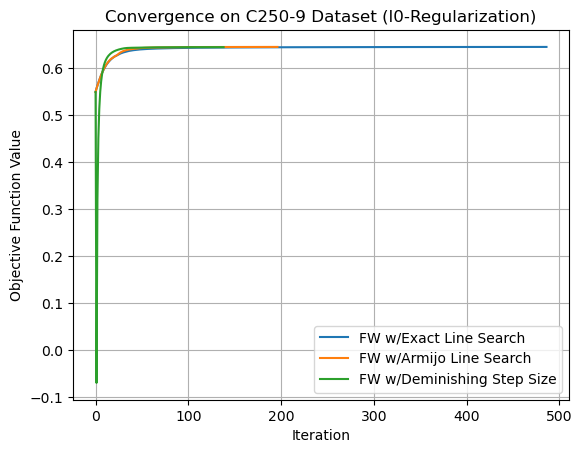

In [24]:
plt.plot(history_FW_exact_l0, label='FW w/Exact Line Search')
plt.plot(history_FW_armijo_l0, label='FW w/Armijo Line Search')
plt.plot(history_FW_demin_l0, label='FW w/Deminishing Step Size')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l0-Regularization)")
plt.legend()
plt.grid(True)
plt.show()


## Away-Step Frank-Wolfe Algorithm (ASFW)

In [28]:
# Frank-Wolfe Away-Step Algorithm
def away_step_frank_wolfe(obj_func, grad_obj_func, A, num_iters, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    x = np.ones(n) / n

    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(num_iters):
        grad = grad_obj_func(x, A)
        vertex_fw = LMO(-grad)
        direction_fw = vertex_fw - x
        gap_fw = np.dot(-grad, direction_fw)
        
        vertex_as = away_step_vertex(x, -grad)
        direction_as = x - vertex_as
        gap_as = np.dot(-grad, direction_as)
        
        #if gap_fw <= epsilon:
           # return x, history
        
        if gap_fw >= gap_as or np.count_nonzero(x) == 1:
            direction = direction_fw
            max_step = 1.0
        else:
            direction = direction_as
            v_idx = np.argmax(x * (x > 0))
            alpha = x[v_idx]
            max_step = alpha / (1 - alpha + 1e-12)

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 2), 1.0)
        else:
            step = min(1.0, max_step)
        
        # Update
        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x
        
        if abs(cur_func - history[-2]) < tol:
            print(f"Converged at iteration {iter+1}, update = {cur_func - history[-2]:.2e}")
            break

        if verbose:
            print(f"Iter {iter+1:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history


#### Test Away-Step Frank-Wolfe Algo on **l2-Regularized Objective Function**

##### Exact Line Search

In [29]:
x_opt_ASFW_exact_l2, history_ASFW_exact_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'exact')


Iter   1: f(x) = 0.902247, step = 0.0981
Iter   2: f(x) = 0.905849, step = 0.0861
Iter   3: f(x) = 0.909616, step = 0.0875
Iter   4: f(x) = 0.912996, step = 0.0830
Iter   5: f(x) = 0.916466, step = 0.0836
Iter   6: f(x) = 0.919963, step = 0.0836
Iter   7: f(x) = 0.923089, step = 0.0792
Iter   8: f(x) = 0.926208, step = 0.0788
Iter   9: f(x) = 0.929282, step = 0.0780
Iter  10: f(x) = 0.932281, step = 0.0769
Iter  11: f(x) = 0.935185, step = 0.0755
Iter  12: f(x) = 0.937976, step = 0.0739
Iter  13: f(x) = 0.940456, step = 0.0698
Iter  14: f(x) = 0.942843, step = 0.0684
Iter  15: f(x) = 0.945131, step = 0.0669
Iter  16: f(x) = 0.947316, step = 0.0653
Iter  17: f(x) = 0.949397, step = 0.0637
Iter  18: f(x) = 0.951259, step = 0.0603
Iter  19: f(x) = 0.953038, step = 0.0590
Iter  20: f(x) = 0.954737, step = 0.0576
Iter  21: f(x) = 0.956267, step = 0.0547
Iter  22: f(x) = 0.957733, step = 0.0536
Iter  23: f(x) = 0.959136, step = 0.0524
Iter  24: f(x) = 0.960408, step = 0.0499
Iter  25: f(x) =

In [31]:
clique_ASFW_exact_l2, size_clique_ASFW_exact_l2 = extract_clique_from_solution(x_opt_ASFW_exact_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_exact_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 36. The best known is of size 44.


##### Armijo Line Search

In [32]:
x_opt_ASFW_armijo_l2, history_ASFW_armijo_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='armijo')

Iter   1: f(x) = 0.901889, step = 0.1250
Iter   2: f(x) = 0.905204, step = 0.1250
Iter   3: f(x) = 0.909226, step = 0.1250
Iter   4: f(x) = 0.913016, step = 0.1250
Iter   5: f(x) = 0.917128, step = 0.1250
Iter   6: f(x) = 0.921333, step = 0.1250
Iter   7: f(x) = 0.925086, step = 0.1250
Iter   8: f(x) = 0.928818, step = 0.1250
Iter   9: f(x) = 0.932428, step = 0.1250
Iter  10: f(x) = 0.935849, step = 0.1250
Iter  11: f(x) = 0.939043, step = 0.1250
Iter  12: f(x) = 0.941993, step = 0.1250
Iter  13: f(x) = 0.944515, step = 0.1250
Iter  14: f(x) = 0.946854, step = 0.1250
Iter  15: f(x) = 0.949001, step = 0.1250
Iter  16: f(x) = 0.950957, step = 0.1250
Iter  17: f(x) = 0.952728, step = 0.1250
Iter  18: f(x) = 0.954232, step = 0.1250
Iter  19: f(x) = 0.955604, step = 0.1250
Iter  20: f(x) = 0.956847, step = 0.1250
Iter  21: f(x) = 0.957907, step = 0.1250
Iter  22: f(x) = 0.958874, step = 0.1250
Iter  23: f(x) = 0.961367, step = 0.0625
Iter  24: f(x) = 0.963591, step = 0.0625
Iter  25: f(x) =

In [33]:
clique_ASFW_armijo_l2, size_clique_ASFW_armijo_l2 = extract_clique_from_solution(x_opt_ASFW_armijo_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 38. The best known is of size 44.


##### Deminishing Step Size

In [34]:
x_opt_ASFW_demin_l2, history_ASFW_demin_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'demin')

Iter   1: f(x) = 0.500000, step = 1.0000
Iter   2: f(x) = 0.722222, step = 0.6667
Iter   3: f(x) = 0.750000, step = 0.5000
Iter   4: f(x) = 0.710000, step = 0.4000
Iter   5: f(x) = 0.740000, step = 0.3333
Iter   6: f(x) = 0.749796, step = 0.2857
Iter   7: f(x) = 0.738520, step = 0.2500
Iter   8: f(x) = 0.749606, step = 0.2222
Iter   9: f(x) = 0.744195, step = 0.2000
Iter  10: f(x) = 0.749999, step = 0.1818
Iter  11: f(x) = 0.743223, step = 0.1667
Iter  12: f(x) = 0.749674, step = 0.1538
Iter  13: f(x) = 0.747421, step = 0.1429
Iter  14: f(x) = 0.749917, step = 0.1333
Iter  15: f(x) = 0.747270, step = 0.1250
Iter  16: f(x) = 0.750000, step = 0.1176
Iter  17: f(x) = 0.746966, step = 0.1111
Iter  18: f(x) = 0.749932, step = 0.1053
Iter  19: f(x) = 0.748325, step = 0.1000
Iter  20: f(x) = 0.749992, step = 0.0952
Iter  21: f(x) = 0.748201, step = 0.0909
Iter  22: f(x) = 0.749993, step = 0.0870
Iter  23: f(x) = 0.748492, step = 0.0833
Iter  24: f(x) = 0.749996, step = 0.0800
Iter  25: f(x) =

In [35]:
clique_ASFW_demin_l2, size_clique_ASFW_demin_l2 = extract_clique_from_solution(x_opt_ASFW_demin_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_demin_l2}. The best known is of size 44.')

Extracted Max Clique is of size: 0. The best known is of size 44.


#### Plot Convergence Results

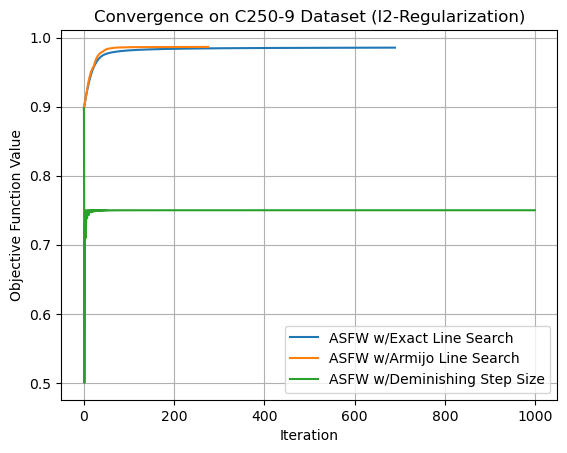

In [36]:
plt.plot(history_ASFW_exact_l2, label='ASFW w/Exact Line Search')
plt.plot(history_ASFW_armijo_l2, label='ASFW w/Armijo Line Search')
plt.plot(history_ASFW_demin_l2, label='ASFW w/Deminishing Step Size')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l2-Regularization)")
plt.legend()
plt.grid(True)
plt.show()

#### Test Away-Step Frank-Wolfe Algo on **l0-Regularized Objective Function**

##### Exact Line Search

In [37]:
x_opt_ASFW_exact_l0, history_ASFW_exact_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'exact')

Iter   1: f(x) = 0.556585, step = 0.1325
Iter   2: f(x) = 0.562682, step = 0.1218
Iter   3: f(x) = 0.568897, step = 0.1218
Iter   4: f(x) = 0.574438, step = 0.1163
Iter   5: f(x) = 0.579851, step = 0.1148
Iter   6: f(x) = 0.585019, step = 0.1123
Iter   7: f(x) = 0.589512, step = 0.1064
Iter   8: f(x) = 0.593746, step = 0.1038
Iter   9: f(x) = 0.597694, step = 0.1008
Iter  10: f(x) = 0.601348, step = 0.0977
Iter  11: f(x) = 0.604711, step = 0.0945
Iter  12: f(x) = 0.607794, step = 0.0913
Iter  13: f(x) = 0.610456, step = 0.0863
Iter  14: f(x) = 0.612910, step = 0.0836
Iter  15: f(x) = 0.615171, step = 0.0809
Iter  16: f(x) = 0.617251, step = 0.0783
Iter  17: f(x) = 0.619164, step = 0.0758
Iter  18: f(x) = 0.620837, step = 0.0720
Iter  19: f(x) = 0.622388, step = 0.0698
Iter  20: f(x) = 0.623826, step = 0.0678
Iter  21: f(x) = 0.624878, step = 0.0553
Iter  22: f(x) = 0.626092, step = 0.0634
Iter  23: f(x) = 0.627222, step = 0.0617
Iter  24: f(x) = 0.628277, step = 0.0600
Iter  25: f(x) =

In [38]:
clique_ASFW_exact_l0, size_clique_ASFW_exact_l0 = extract_clique_from_solution(x_opt_ASFW_exact_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_exact_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 35. The best known is of size 44.


##### Armijo Line Search

In [39]:
x_opt_ASFW_armijo_l0, history_ASFW_armijo_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'armijo')

Iter   1: f(x) = 0.556555, step = 0.1250
Iter   2: f(x) = 0.562516, step = 0.1250
Iter   3: f(x) = 0.568701, step = 0.1250
Iter   4: f(x) = 0.574239, step = 0.1250
Iter   5: f(x) = 0.579747, step = 0.1250
Iter   6: f(x) = 0.585058, step = 0.1250
Iter   7: f(x) = 0.589680, step = 0.1250
Iter   8: f(x) = 0.594089, step = 0.1250
Iter   9: f(x) = 0.598223, step = 0.1250
Iter  10: f(x) = 0.602048, step = 0.1250
Iter  11: f(x) = 0.605552, step = 0.1250
Iter  12: f(x) = 0.608735, step = 0.1250
Iter  13: f(x) = 0.611435, step = 0.1250
Iter  14: f(x) = 0.613906, step = 0.1250
Iter  15: f(x) = 0.616151, step = 0.1250
Iter  16: f(x) = 0.618179, step = 0.1250
Iter  17: f(x) = 0.620002, step = 0.1250
Iter  18: f(x) = 0.620888, step = 0.1250
Iter  19: f(x) = 0.622502, step = 0.1250
Iter  20: f(x) = 0.623910, step = 0.1250
Iter  21: f(x) = 0.625142, step = 0.1250
Iter  22: f(x) = 0.626168, step = 0.1250
Iter  23: f(x) = 0.627081, step = 0.1250
Iter  24: f(x) = 0.628858, step = 0.0625
Iter  25: f(x) =

In [40]:
clique_ASFW_armijo_l0, size_clique_ASFW_armijo_l0 = extract_clique_from_solution(x_opt_ASFW_armijo_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 34. The best known is of size 44.


##### Deminishing Step Size

In [41]:
x_opt_ASFW_demin_l0, history_ASFW_demin_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'demin')

Iter   1: f(x) = -0.069528, step = 1.0000
Iter   2: f(x) = 0.320163, step = 0.6667
Iter   3: f(x) = 0.371492, step = 0.5000
Iter   4: f(x) = 0.297733, step = 0.4000
Iter   5: f(x) = 0.352959, step = 0.3333
Iter   6: f(x) = 0.371113, step = 0.2857
Iter   7: f(x) = 0.350222, step = 0.2500
Iter   8: f(x) = 0.370761, step = 0.2222
Iter   9: f(x) = 0.360726, step = 0.2000
Iter  10: f(x) = 0.371491, step = 0.1818
Iter  11: f(x) = 0.358925, step = 0.1667
Iter  12: f(x) = 0.370886, step = 0.1538
Iter  13: f(x) = 0.366707, step = 0.1429
Iter  14: f(x) = 0.371338, step = 0.1333
Iter  15: f(x) = 0.366427, step = 0.1250
Iter  16: f(x) = 0.371492, step = 0.1176
Iter  17: f(x) = 0.365863, step = 0.1111
Iter  18: f(x) = 0.371366, step = 0.1053
Iter  19: f(x) = 0.368383, step = 0.1000
Iter  20: f(x) = 0.371477, step = 0.0952
Iter  21: f(x) = 0.368154, step = 0.0909
Iter  22: f(x) = 0.371479, step = 0.0870
Iter  23: f(x) = 0.368694, step = 0.0833
Iter  24: f(x) = 0.371485, step = 0.0800
Iter  25: f(x) 

In [42]:
clique_ASFW_demin_l0, size_clique_ASFW_demin_l0 = extract_clique_from_solution(x_opt_ASFW_demin_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_demin_l0}. The best known is of size 44.')

Extracted Max Clique is of size: 0. The best known is of size 44.


#### Plot Convergence Results

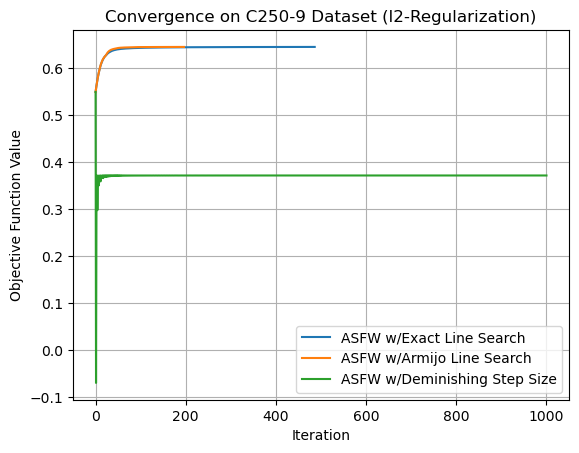

In [43]:
plt.plot(history_ASFW_exact_l0, label='ASFW w/Exact Line Search')
plt.plot(history_ASFW_armijo_l0, label='ASFW w/Armijo Line Search')
plt.plot(history_ASFW_demin_l0, label='ASFW w/Deminishing Step Size')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l2-Regularization)")
plt.legend()
plt.grid(True)
plt.show()

## Pairwise Frank-Wolfe (PFW)

In [ ]:
# Pairwise Frank-Wolfe Algorithm
def pairwise_frank_wolfe(obj_func, grad_obj_func, A, x0, num_iters=100, use_line_search=False, verbose=True):
    n = A.shape[0]
    x = np.ones(n) / n

    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(num_iters):
        grad = grad_obj_func(x, A)
        s_fw = LMO(-grad)
        s_as = away_step_vertex(x, grad)
        direction = s_fw - s_as

        if use_line_search:
            step = line_search(lambda z: obj_func(z, A), x, direction, max_step=max_step)
        else:
            step = 2 / (iter + 2)

        # Update
        x += step * direction
        fx = obj_func(x, A)
        history.append(fx)

        if verbose:
            print(f"Iter {iter+1:3d}: f(x) = {fx:.6f}, γ = {step:.4f}")

    return x, history

In [24]:

x_opt_PFW_fb, history_PRW_fb = pairwise_frank_wolfe(obj_l2, grad_l2, A, x, num_iters=1000, use_line_search=False)

NameError: name 'alpha' is not defined

In [20]:
x_opt_PFW_fb_ls, history_PRW_fb_ls = pairwise_frank_wolfe(obj_l2, grad_l2, A, x, num_iters=1000, use_line_search=True)

NameError: name 'max_step' is not defined

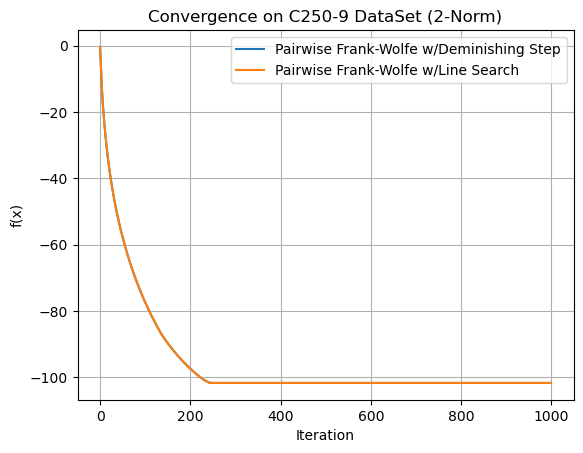

In [26]:
plt.plot(history_PRW_fb, label='Pairwise Frank-Wolfe w/Deminishing Step')
plt.plot(history_PRW_fb_ls, label='Pairwise Frank-Wolfe w/Line Search')
plt.xlabel("Iteration")
plt.ylabel("f(x)")
plt.title("Convergence on C250-9 DataSet (2-Norm)")
plt.legend()
plt.grid(True)
plt.show()
